## 0. Librerías necesarias para ejecutar el código

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from itertools import product
import stellargraph as sg
from stellargraph import StellarGraph
import os
import sys
import urllib.request

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
#!pip install pydot
import pydot
import sklearn.metrics as metrics
import pickle

##  1. Sensores y nodos donde se encuentran los sensores

En este apartado se lee la tabla de sensores y se crea un grafo con sus conexiones.
Además, se lee la tabla de series temporales y se ponen en el formato input del modelo

In [2]:
pd_nodes_sensor = pd.read_csv("pd_nodes_dual_final.csv")
pd_nodes_sensor['id'] = pd_nodes_sensor['id'].astype(int)

pd_data_sensor = pd.read_csv("pd_grouped_sensor_2021.csv")\
                   .drop(['Unnamed: 0'],axis=1)

In [4]:

pd_data_sensor_selected = pd.read_csv("pd_id_sensor_selected.csv")\
                            .drop(['Unnamed: 0'],axis=1)
pd_data_sensor_f = pd_data_sensor\
                        .merge(pd_data_sensor_selected, 
                               right_on='id_selected', 
                               left_on='id', how='inner')
speed_data = pd_data_sensor_f\
                    .sort_values('fecha')\
                    .pivot(index='id', columns='fecha', values='intensidad')\
                    .fillna(0)\
                    .reset_index()\
                    .merge(pd_nodes_sensor, on=['id'], how='inner')

speed_data_f = speed_data\
                .drop_duplicates(subset=['name_node'])\
                .sort_values('name_node')\
                .set_index('name_node')\
                .drop(['Unnamed: 0', 'id', 'pd_edges', 'u', 'v'], axis=1)\
# 
speed_data_f.head()

,2021-01-01 00,2021-01-01 01,2021-01-01 02,2021-01-01 03,2021-01-01 04,2021-01-01 05,2021-01-01 06,2021-01-01 07,2021-01-01 08,2021-01-01 09,...,2021-11-30 14,2021-11-30 15,2021-11-30 16,2021-11-30 17,2021-11-30 18,2021-11-30 19,2021-11-30 20,2021-11-30 21,2021-11-30 22,2021-11-30 23
name_node,,,,,,,,,,,,,,,,,,,,,
X10005,1408.0,3465.0,520.0,314.0,105.0,218.0,818.0,984.0,528.0,689.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10006,1769.0,5629.0,1409.0,640.0,440.0,449.0,923.0,1418.0,1524.0,885.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X1002,1595.0,8277.0,927.0,255.0,161.0,207.0,1177.0,1887.0,1251.0,1365.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X100203,567.0,1548.0,205.0,12.0,5.0,10.0,162.0,235.0,155.0,169.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10030,249.0,715.0,187.0,94.0,74.0,90.0,145.0,464.0,321.0,275.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
speed_data_f.shape

(1482, 8016)

## 2. Creación de la matriz de adyacencia: conexiones y pesos

Se crea una matruz de adyacencia con las situaciones espaciales de los sensores y la inversa de su camino minimo como peso entre ellos

In [7]:
pd_graph_conexion = pd.read_csv("pd_path_sensor_shortest2_path_920000.csv")\
                      .drop(['Unnamed: 0'],axis=1)
pd_graph_conexion['weight'] = pd_graph_conexion['shortest_path']\
                                                .astype(str)\
                                                .apply(lambda x: x.split(",")[0][1:])\
                                                .astype(float).apply(lambda x: float(1/(x+10)))

pd_graph_conexion.shape

(920000, 6)

In [8]:
pd_graph_conexion['weight'].describe([.8,.9, .95, .99])

count    920000.000000
mean          0.000444
std           0.002604
min           0.000128
50%           0.000326
80%           0.000442
90%           0.000542
95%           0.000670
99%           0.001184
max           0.100000
Name: weight, dtype: float64

In [9]:
pd_graph_conexion = pd_graph_conexion[pd_graph_conexion['weight']>0.001]
pd_graph_conexion.head()

,Unnamed: 0.1,Unnamed: 0.1.1,from,to,shortest_path,weight
0,0.0,0.0,X33,X33,"(0, ['X33'])",0.100000
1,1.0,1.0,X33,X38,"(787.2410000000002, ['X33', 'X175202', 'X189',...",0.001254
2,2.0,2.0,X33,X60,"(721.762, ['X33', 'X175202', 'X189', 'X175201'...",0.001367
6,6.0,6.0,X33,X190,"(125.31799999999998, ['X33', 'X175202', 'X189'...",0.007390
8,8.0,8.0,X33,X296,"(693.4689999999999, ['X33', 'X175202', 'X189',...",0.001422


In [10]:
l = list(set(sum([pd_graph_conexion['from'].to_list(), 
                  pd_graph_conexion['to'].to_list()], [])))

speed_data_f = speed_data_f[speed_data_f.index.isin(l)]

In [11]:
pd_all_data = pd.DataFrame(list(product(pd_graph_conexion['to'].unique(), pd_graph_conexion['to'].unique())), 
             columns=['from', 'to'])
print(pd_all_data.shape)
pd_merged_data = pd_all_data.merge(pd_graph_conexion, 
                  on=['from', 'to'], how='left')
pd_merged_data_f = pd_merged_data[['from', 'to', 'weight']].fillna(0)

sensor_dist_adj = np.asmatrix(pd.pivot_table(pd_merged_data_f.sort_values('from'), values='weight', index=['from'],
                    columns=['to']).to_numpy())
sensor_dist_adj.shape

(1547536, 2)


(1244, 1244)

## 3. Modelo predictivo

para realizar el modelo, es necesario separar en train, validación y test y escalar los datos. Posteriormente, las series temporales se ponen en el formato input de una LSTM

In [15]:
num_nodes, time_len = speed_data_f.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 1244 
No of timesteps: 8016


### 3.1. Separación en train, validación y test

In [16]:
def train_test_split(data, train_portion):
    
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    print('train_size', train_size)
    train_data = np.array(data.iloc[:, :train_size])#train_size
    test_data = np.array(data.iloc[:, train_size:-24])#-840:-791
    test2_data = np.array(data.iloc[:, -24:])

    return train_data, test_data, test2_data

In [17]:
train_rate = 0.8
train_data, test_data,test2_data = train_test_split(speed_data_f, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

train_size 6412
Index(['2021-10-27 00', '2021-10-27 01', '2021-10-27 02', '2021-10-27 03',
       '2021-10-27 04', '2021-10-27 05', '2021-10-27 06', '2021-10-27 07',
       '2021-10-27 08', '2021-10-27 09', '2021-10-27 10', '2021-10-27 11',
       '2021-10-27 12', '2021-10-27 13', '2021-10-27 14', '2021-10-27 15',
       '2021-10-27 16', '2021-10-27 17', '2021-10-27 18', '2021-10-27 19',
       '2021-10-27 20', '2021-10-27 21', '2021-10-27 22', '2021-10-27 23',
       '2021-10-28 00', '2021-10-28 01', '2021-10-28 02', '2021-10-28 03',
       '2021-10-28 04', '2021-10-28 05', '2021-10-28 06', '2021-10-28 07',
       '2021-10-28 08', '2021-10-28 09', '2021-10-28 10', '2021-10-28 11',
       '2021-10-28 12', '2021-10-28 13', '2021-10-28 14', '2021-10-28 15',
       '2021-10-28 16', '2021-10-28 17', '2021-10-28 18', '2021-10-28 19',
       '2021-10-28 20', '2021-10-28 21', '2021-10-28 22', '2021-10-28 23',
       '2021-10-29 00'],
      dtype='object')
Train data:  (1244, 6412)
Test data: 

### 3.2. Escalado de datos

In [18]:
def scale_data(train_data, test_data, test2):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    test2 = (test2 - min_speed) / (max_speed - min_speed)
    #train_scaled = (train_data - train_data.mean()) / train_data.std()
    #test_scaled = (test_data - train_data.mean()) / train_data.std()
    return train_scaled, test_scaled, test2

train_scaled, test_scaled, test2 = scale_data(train_data, test_data, test2_data)

## 3.3 Creación de ventanas

Se crean ventanas porque el formato input de las series temporales sigue la estructura input de las capas LSTM

In [20]:
seq_len = 24
pre_len = 1

def sequence_data_preparation(seq_len, pre_len, train_data, test_data, test2_data):
    trainX, trainY, testX, testY , test2X, test2Y= [], [], [], [],[],[]

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        #trainY.append(a[:, -pre_len:])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        #testY.append(b[:, -pre_len:])
        testY.append(b[:, -1])
        
    for i in range(test2_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test2_data[:, i : i + seq_len + pre_len]
        test2X.append(b[:, :seq_len])
        #testY.append(b[:, -pre_len:])
        test2Y.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)#.reshape(len(trainY),-1)
    testX = np.array(testX)
    testY = np.array(testY)#.reshape(len(testY),-1)
    test2X = np.array(testX)
    test2Y = np.array(testY)#.reshape(len(testY),-1)
    
    return trainX, trainY, testX, testY, test2X, test2Y

trainX, trainY, testX, testY , test2X, test2Y= sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled, test2
)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
print(test2X.shape)
print(test2Y.shape)

(6388, 1244, 24)
(6388, 1244)
(740, 1244, 24)
(740, 1244)
(740, 1244, 24)
(740, 1244)


In [96]:
from stellargraph.layer import GCN_LSTM
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

C:\Users\ARIASBO\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  


In [97]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [99]:

model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer="adam", loss="mae", metrics=["mse"])
history = model.fit(
    trainX,
    trainY,
    epochs=500,
    batch_size=60,
    shuffle=True,
    verbose=1,
    validation_data=(testX, testY),
)# 1000
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))
model.summary()

Epoch 1/500
107/107 [==============================] - 17s 122ms/step - loss: 0.0593 - mse: 0.0215 - val_loss: 0.0046 - val_mse: 6.6522e-05
Epoch 2/500
107/107 [==============================] - 12s 112ms/step - loss: 0.0044 - mse: 6.4668e-05 - val_loss: 0.0044 - val_mse: 5.6661e-05
Epoch 3/500
107/107 [==============================] - 12s 112ms/step - loss: 0.0043 - mse: 6.2513e-05 - val_loss: 0.0044 - val_mse: 5.5358e-05
Epoch 4/500
107/107 [==============================] - 13s 122ms/step - loss: 0.0043 - mse: 6.1548e-05 - val_loss: 0.0044 - val_mse: 5.3844e-05
Epoch 5/500
107/107 [==============================] - 16s 153ms/step - loss: 0.0043 - mse: 6.0403e-05 - val_loss: 0.0044 - val_mse: 5.2815e-05
Epoch 6/500
107/107 [==============================] - 24s 221ms/step - loss: 0.0042 - mse: 5.8981e-05 - val_loss: 0.0043 - val_mse: 4.9947e-05
Epoch 7/500
107/107 [==============================] - 23s 215ms/step - loss: 0.0042 - mse: 5.7894e-05 - val_loss: 0.0043 - val_mse: 5.0101e

107/107 [==============================] - 21s 197ms/step - loss: 0.0018 - mse: 1.8529e-05 - val_loss: 0.0013 - val_mse: 9.2439e-06
Epoch 114/500
107/107 [==============================] - 21s 196ms/step - loss: 0.0017 - mse: 1.8280e-05 - val_loss: 0.0015 - val_mse: 1.0196e-05
Epoch 115/500
107/107 [==============================] - 20s 182ms/step - loss: 0.0017 - mse: 1.8202e-05 - val_loss: 0.0017 - val_mse: 1.1236e-05
Epoch 116/500
107/107 [==============================] - 16s 151ms/step - loss: 0.0017 - mse: 1.8432e-05 - val_loss: 0.0015 - val_mse: 1.0129e-05
Epoch 117/500
107/107 [==============================] - 21s 194ms/step - loss: 0.0017 - mse: 1.8141e-05 - val_loss: 0.0016 - val_mse: 1.0670e-05
Epoch 118/500
107/107 [==============================] - 21s 200ms/step - loss: 0.0017 - mse: 1.8040e-05 - val_loss: 0.0013 - val_mse: 9.0850e-06
Epoch 119/500
107/107 [==============================] - 21s 196ms/step - loss: 0.0017 - mse: 1.8132e-05 - val_loss: 0.0013 - val_mse: 9.2

107/107 [==============================] - 22s 207ms/step - loss: 0.0011 - mse: 1.2666e-05 - val_loss: 0.0011 - val_mse: 6.8812e-06
Epoch 226/500
107/107 [==============================] - 23s 216ms/step - loss: 0.0011 - mse: 1.2557e-05 - val_loss: 0.0011 - val_mse: 7.0191e-06
Epoch 227/500
107/107 [==============================] - 24s 223ms/step - loss: 0.0011 - mse: 1.2514e-05 - val_loss: 0.0011 - val_mse: 7.0121e-06
Epoch 228/500
107/107 [==============================] - 23s 211ms/step - loss: 0.0011 - mse: 1.2570e-05 - val_loss: 0.0010 - val_mse: 6.7603e-06
Epoch 229/500
107/107 [==============================] - 22s 207ms/step - loss: 0.0011 - mse: 1.2499e-05 - val_loss: 0.0010 - val_mse: 6.6702e-06
Epoch 230/500
107/107 [==============================] - 22s 208ms/step - loss: 0.0011 - mse: 1.2475e-05 - val_loss: 0.0010 - val_mse: 6.8061e-06
Epoch 231/500
107/107 [==============================] - 23s 211ms/step - loss: 0.0011 - mse: 1.2448e-05 - val_loss: 0.0011 - val_mse: 6.7

107/107 [==============================] - 22s 203ms/step - loss: 7.6411e-04 - mse: 1.0694e-05 - val_loss: 8.5604e-04 - val_mse: 5.5722e-06
Epoch 333/500
107/107 [==============================] - 16s 146ms/step - loss: 7.6240e-04 - mse: 1.0686e-05 - val_loss: 8.6818e-04 - val_mse: 5.6032e-06
Epoch 334/500
107/107 [==============================] - 15s 144ms/step - loss: 7.6120e-04 - mse: 1.0680e-05 - val_loss: 8.7406e-04 - val_mse: 5.6102e-06
Epoch 335/500
107/107 [==============================] - 15s 145ms/step - loss: 7.5807e-04 - mse: 1.0657e-05 - val_loss: 8.6652e-04 - val_mse: 5.6431e-06
Epoch 336/500
107/107 [==============================] - 16s 146ms/step - loss: 7.6082e-04 - mse: 1.0657e-05 - val_loss: 8.9485e-04 - val_mse: 5.7185e-06
Epoch 337/500
107/107 [==============================] - 16s 145ms/step - loss: 7.6134e-04 - mse: 1.0657e-05 - val_loss: 8.5618e-04 - val_mse: 5.5637e-06
Epoch 338/500
107/107 [==============================] - 23s 211ms/step - loss: 7.6034e-04

107/107 [==============================] - 23s 211ms/step - loss: 6.6756e-04 - mse: 9.5065e-06 - val_loss: 7.4450e-04 - val_mse: 4.1119e-06
Epoch 439/500
107/107 [==============================] - 22s 210ms/step - loss: 6.6571e-04 - mse: 9.4832e-06 - val_loss: 7.3767e-04 - val_mse: 4.1413e-06
Epoch 440/500
107/107 [==============================] - 22s 203ms/step - loss: 6.6607e-04 - mse: 9.4389e-06 - val_loss: 7.4496e-04 - val_mse: 4.1241e-06
Epoch 441/500
107/107 [==============================] - 23s 209ms/step - loss: 6.6329e-04 - mse: 9.4223e-06 - val_loss: 7.5077e-04 - val_mse: 4.1643e-06
Epoch 442/500
107/107 [==============================] - 22s 206ms/step - loss: 6.6852e-04 - mse: 9.4305e-06 - val_loss: 7.6367e-04 - val_mse: 4.2460e-06
Epoch 443/500
107/107 [==============================] - 23s 211ms/step - loss: 6.6227e-04 - mse: 9.3883e-06 - val_loss: 7.4110e-04 - val_mse: 4.1044e-06
Epoch 444/500
107/107 [==============================] - 22s 208ms/step - loss: 6.6637e-04

INFO:tensorflow:Assets written to: ram://87c83924-b758-4252-8aaa-b950207c03ff/assets


INFO:tensorflow:Assets written to: ram://87c83924-b758-4252-8aaa-b950207c03ff/assets


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1244, 24)]        0         
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 1244, 24, 1)      0         
 a)                                                              
                                                                 
 reshape_6 (Reshape)         (None, 1244, 24)          0         
                                                                 
 fixed_adjacency_graph_convo  (None, 1244, 16)         1549164   
 lution_4 (FixedAdjacencyGra                                     
 phConvolution)                                                  
                                                                 
 fixed_adjacency_graph_convo  (None, 1244, 10)         1548940   
 lution_5 (FixedAdjacencyGra                               

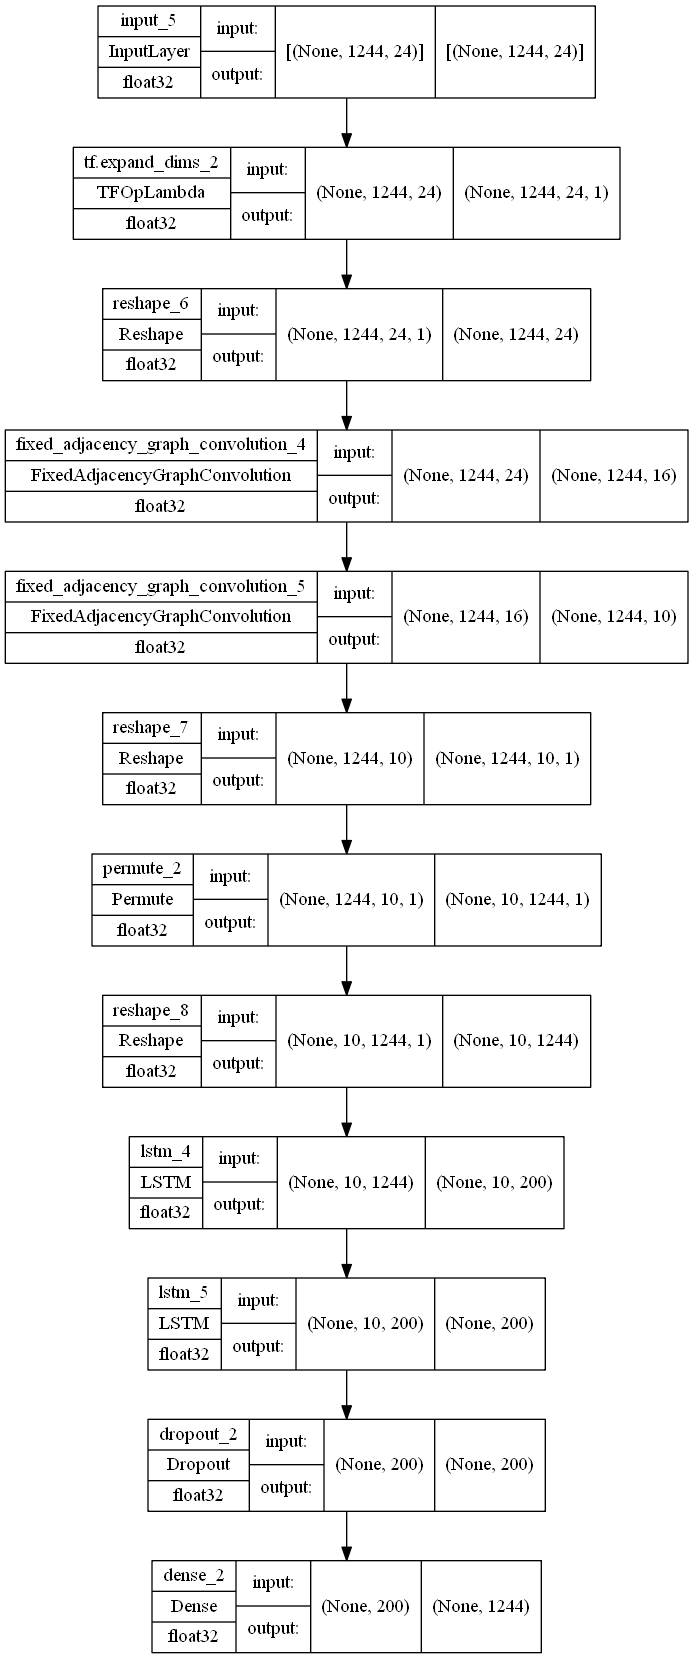

In [123]:
keras.utils.plot_model(model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True,  
                       to_file='model.png')

## 4. Evaluación del modelo

<AxesSubplot:title={'center':'Función de coste MAE. Tase de aprendizaje 0,001. Número de épocas 500. Tamaño de batch 60. Dos capas GCN (16 y 10) y dos capas LSTM (200 y 200)'}>

<Figure size 432x288 with 0 Axes>

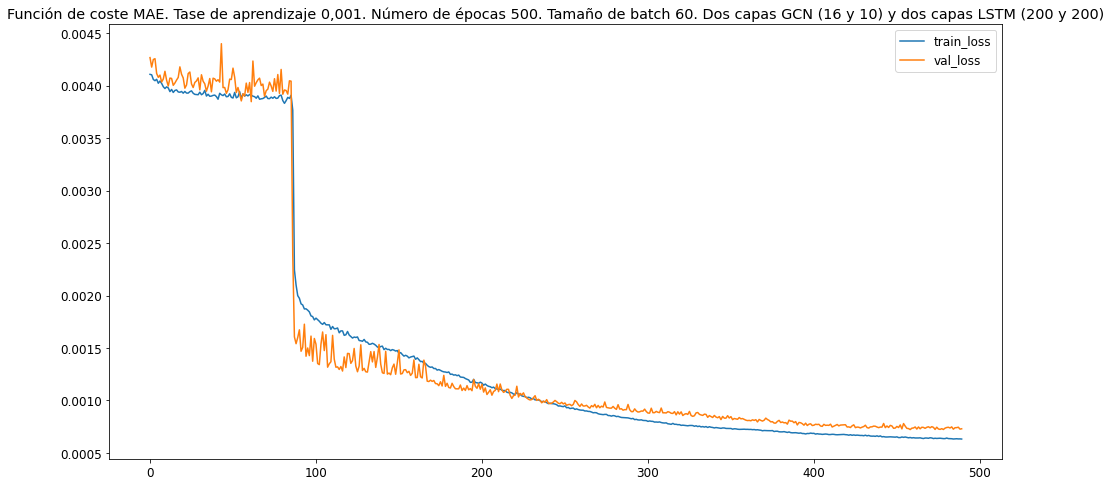

In [126]:
plt.figure()
plt.rcParams.update({'font.size': 12}) # must set in top
pd.DataFrame({'train_loss':history.history["loss"][10:],
              'val_loss':history.history["val_loss"][10:]})\
    .plot(figsize=[16,8], title='Función de coste MAE. Tase de aprendizaje 0,001. Número de épocas 500. Tamaño de batch 60. Dos capas GCN (16 y 10) y dos capas LSTM (200 y 200)',
         fontsize=12)


<AxesSubplot:title={'center':'Función de coste MSE. Tase de aprendizaje 0,001. Número de épocas 500. Tamaño de batch 60. Dos capas GCN (64 y 32) y dos capas LSTM (32 y 12)'}>

<Figure size 432x288 with 0 Axes>

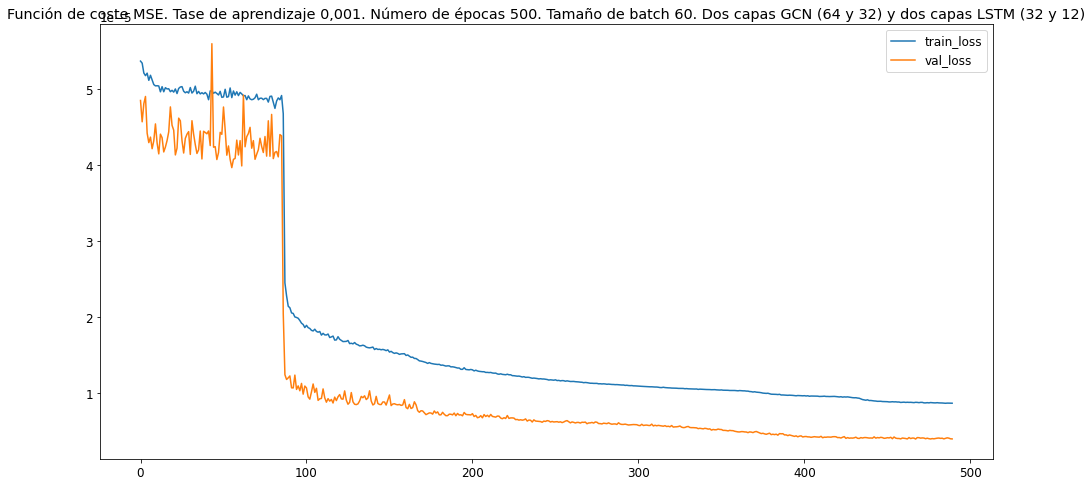

In [127]:
plt.figure()
plt.rcParams.update({'font.size': 12}) # must set in top
pd.DataFrame({'train_loss':history.history["mse"][10:],
              'val_loss':history.history["val_mse"][10:]})\
    .plot(figsize=[16,8], title='Función de coste MSE. Tase de aprendizaje 0,001. Número de épocas 500. Tamaño de batch 60. Dos capas GCN (64 y 32) y dos capas LSTM (32 y 12)',
         fontsize=12)

In [129]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

In [147]:

mae = metrics.mean_absolute_error(ythat, trainY)
mse = metrics.mean_squared_error(ythat, trainY)
mape = metrics.mean_absolute_percentage_error(ythat, trainY)

rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(ythat, trainY)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("mape:", mape)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.0005256615138942673
MSE: 8.175807930731373e-06
RMSE: 0.002859336973973402
mape: 4875.132085434198
R-Squared: 0.34381734215888254


In [148]:
import numpy as np 
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

mae = metrics.mean_absolute_error(yhat, testY)
mse = metrics.mean_squared_error(yhat, testY)
mape = metrics.mean_absolute_percentage_error(yhat, testY)

rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(yhat, testY)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("mape:", mape)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.0007296576191893312
MSE: 4.018281608433137e-06
RMSE: 0.002004565191864095
mape: 4.39115269020762
R-Squared: -936.3775548200964


In [132]:
trainX.shape

(6388, 1244, 24)

In [134]:
trainY[0].flatten()#.shape

array([1.91256382e-03, 5.25613033e-03, 6.01951417e-05, ...,
       1.75113140e-03, 6.42993559e-04, 1.57601826e-03])

### Se deshace el escalado de los datos

In [136]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()
## (a-b)*x + a
## actual train and test values
train_rescref = np.array(((max_speed-min_speed)*trainY) + max_speed)
test_rescref = np.array((max_speed-min_speed)*testY +max_speed)
## Rescale model predicted values
train_rescpred = np.array(((max_speed-min_speed)*ythat) + max_speed)
test_rescpred = np.array(((max_speed-min_speed)*yhat) + max_speed)

In [139]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1244, 24)]        0         
                                                                 
 tf.expand_dims_2 (TFOpLambd  (None, 1244, 24, 1)      0         
 a)                                                              
                                                                 
 reshape_6 (Reshape)         (None, 1244, 24)          0         
                                                                 
 fixed_adjacency_graph_convo  (None, 1244, 16)         1549164   
 lution_4 (FixedAdjacencyGra                                     
 phConvolution)                                                  
                                                                 
 fixed_adjacency_graph_convo  (None, 1244, 10)         1548940   
 lution_5 (FixedAdjacencyGra                               

### Algunas visualizaciones de las predicciones

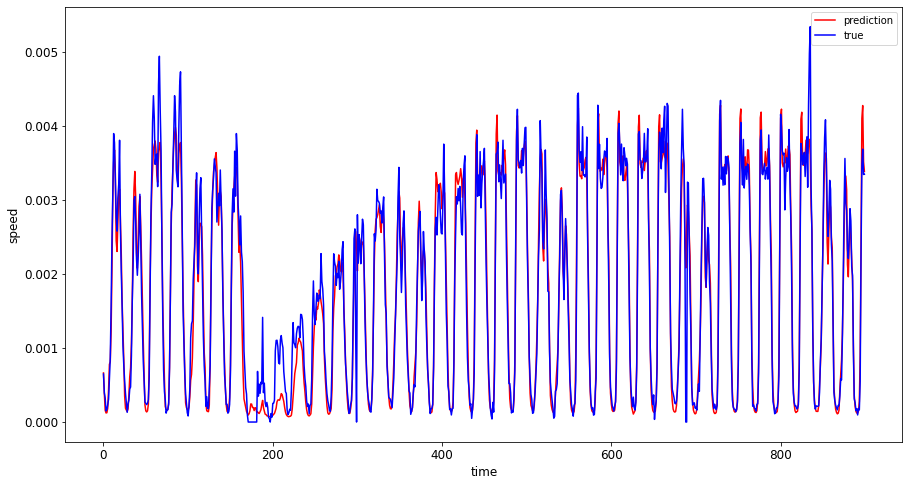

In [143]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = ythat[:, 10][:900]
a_true = trainY[:,10][:900]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()


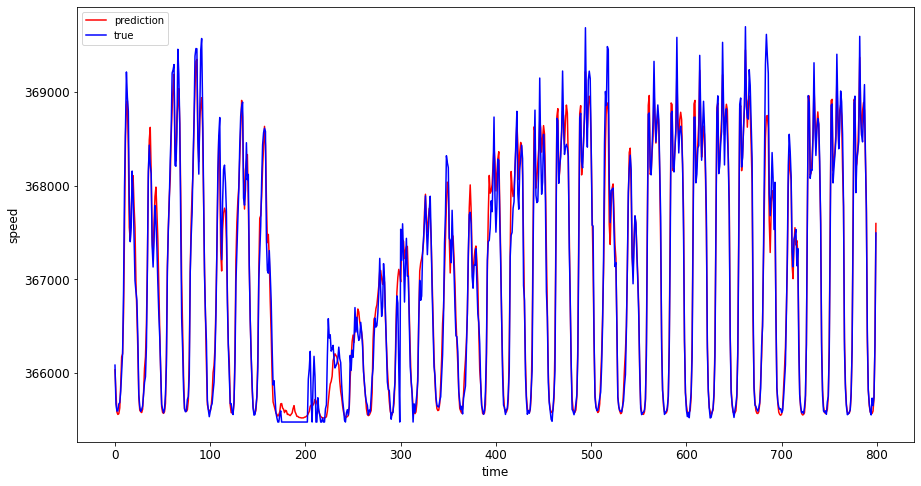

In [144]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = train_rescpred[:, 30][:800]
a_true = train_rescref[:, 30][:800]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

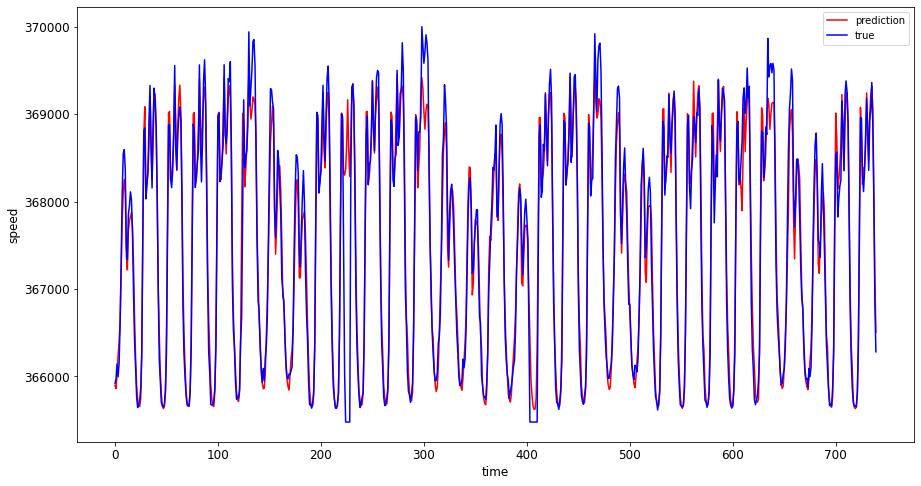

In [145]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 30]
a_true = test_rescref[:, 30]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

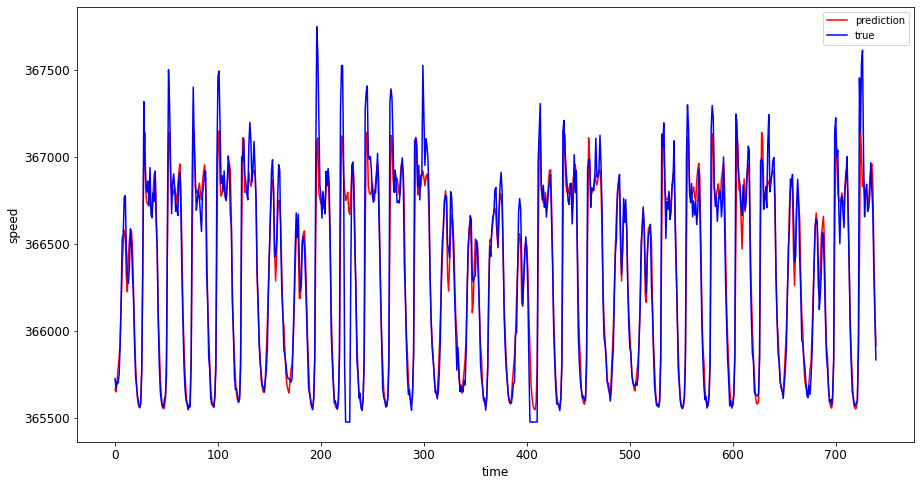

In [146]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 10]
a_true = test_rescref[:, 10]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

## Evaluaciones sobre la muestra de test

### predicciones a 24h

In [ ]:
ythat = model.predict(trainX)
yhat = model.predict(testX)
test_new = test2X.copy()
result_24h = []
#test_new = np.zeros([1, test2X.shape[1], test2X.shape[2]])
len_pred = 24
for i in range(len_pred):

    yhat2 = model.predict(test_new)
    result_24h.append(yhat2)
    test_new[:, :, :len_pred-1]= test_new[:,:,1:]
    test_new[:, :, -1] = yhat2

pd.DataFrame(np.array(result_24h).squeeze())#.shape
max_speed = train_data.max()
min_speed = train_data.min()
pd_time_series_pred24 = ((pd.DataFrame(np.array(result_24h).squeeze()))-min_speed)*(max_speed-min_speed)
pd_time_series_pred24.columns = l_name_sensor


pd_time_series_real24 = (pd.DataFrame(test2Y).T-min_speed)*(max_speed-min_speed)

pd_time_series_real24.columns = l_name_sensor
pd_time_series_modelo_base_real24 = (pd.DataFrame(test_mod_base).T-min_speed)*(max_speed-min_speed)
pd_time_series_modelo_base_real24.columns = l_name_sensor
print(pd_time_series_pred24.shape, pd_time_series_real24.shape, pd_time_series_modelo_base_real24.shape)

In [ ]:

pd_result_pred_tbl = pd.DataFrame()
pd_result_pred_tbl['values_pred'] = pd_time_series_pred24.iloc[:,0]
pd_result_pred_tbl['name_node'] = pd_time_series_pred24.columns[0]
pd_result_pred_tbl['range'] = list(range(24))
pd_interm = pd.DataFrame()

for i in range(1,pd_time_series_pred24.shape[1]):
    
    pd_interm['values_pred'] = pd_time_series_pred24.iloc[:,i]
    pd_interm['name_node'] = pd_time_series_pred24.columns[i]
    pd_interm['range'] = list(range(24))
    pd_result_pred_tbl = pd.concat([pd_interm, pd_result_pred_tbl],axis=0)

pd_result_real_tbl = pd.DataFrame()
pd_result_real_tbl['values_real'] = pd_time_series_real24.iloc[:,0]
pd_result_real_tbl['name_node'] = pd_time_series_real24.columns[0]
pd_result_real_tbl['range'] = list(range(24))
pd_interm = pd.DataFrame()

for i in range(1,pd_time_series_real24.shape[1]):
    
    pd_interm['values_real'] = pd_time_series_real24.iloc[:,i]
    pd_interm['name_node'] = pd_time_series_real24.columns[i]
    pd_interm['range'] = list(range(24))
    pd_result_real_tbl = pd.concat([pd_interm, pd_result_real_tbl],axis=0)
    
df_results = pd_result_real_tbl.merge(pd_result_pred_tbl, on=['name_node', 'range'], how='inner')    
df_results.to_csv('resultados_f.csv')


### Evaluación en zonas particulares de madrid

In [ ]:
df_real = pd_time_series_real24.loc[:,['X2321', 'X2323', 'X2326', 'X2333', 'X2390', 'X9457', 'X18580',
                               'X18585','X18595', 'X1598', 'X18599']]
df_pred = pd_time_series_pred24.loc[:,['X2321', 'X2323', 'X2326', 'X2333', 'X2390', 'X9457', 'X18580',
                               'X18585','X18595', 'X1598', 'X18599']]
df_pred_base = pd_time_series_modelo_base_real24.loc[:,['X2321', 'X2323', 'X2326', 'X2333', 'X2390', 'X9457', 'X18580',
                               'X18585','X18595', 'X1598', 'X18599']]
# 'X6120'
for i in range(df_real.shape[1]):

    plt.figure(figsize=(16,8))
    df_real.iloc[:,i].plot(color='skyblue', title=str(df_real.columns[i]), label="real")
    df_pred.iloc[:,i].plot(color='red', label="predicho con T-GCN")
    df_pred_base.iloc[:,i].plot(color='orange', label = "predicho con modelo base")
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
l = ['X6120','X111437', 'X1083', 'X1086', 'X173709', 'X6120', 'X8035',
       'X136238', 'X139603', 'X151560', 'X152914', 'X154526', 'X160503',
       'X184732', 'X8011', 'X96459', 'X114644', 'X126204', 'X131611',
       'X136239', 'X148050', 'X151558', 'X178921', 'X184739', 'X153541',
       'X8614', 'X12723', 'X83489', 'X107837', 'X127459', 'X169218']
l = ['X1083', 'X1086', 'X6120', 'X8035', 'X139603', 'X152914',
       'X154526', 'X160503', 'X184732']
df_real = pd_time_series_real24.loc[:,l]
df_pred = pd_time_series_pred24.loc[:,l]
df_pred_base = pd_time_series_modelo_base_real24.loc[:,l]

for i in range(df_real.shape[1]):

    plt.figure(figsize=(16,8))
    df_real.iloc[:,i].plot(color='skyblue', title=df_real.columns[i], label="valores reales")
    df_pred.iloc[:,i].plot(color='red', label="predicho con el modelo T-GCN")
    df_pred_base.iloc[:,i].plot(color='orange', label="predicho con el modelo base")
    plt.legend(loc="upper left")
    plt.show()

### predicción a 2h

In [ ]:
#metrics.mean_absolute_error(pd_time_series_pred24, pd_time_series_real24)
mae = metrics.mean_absolute_error(pd_time_series_pred24.head(2), pd_time_series_real24.head(2))
mse = metrics.mean_squared_error(pd_time_series_pred24.head(2), pd_time_series_real24.head(2))
mape = metrics.mean_absolute_percentage_error(pd_time_series_pred24.head(2), pd_time_series_real24.head(2))

rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(pd_time_series_pred24.head(2), pd_time_series_real24.head(2))

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("mape:", mape)
print("R-Squared:", r2)

In [ ]:
#metrics.mean_absolute_error(pd_time_series_pred24, pd_time_series_real24)
mae = metrics.mean_absolute_error(pd_time_series_modelo_base_real24.head(2), pd_time_series_real24.head(2))
mse = metrics.mean_squared_error(pd_time_series_modelo_base_real24.head(2), pd_time_series_real24.head(2))
mape = metrics.mean_absolute_percentage_error(pd_time_series_modelo_base_real24.head(2), pd_time_series_real24.head(2))

rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(pd_time_series_modelo_base_real24.head(2), pd_time_series_real24.head(2))

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("mape:", mape)
print("R-Squared:", r2)